<img src='https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/tools/frameworks/-/raw/main/img/Standard_banner.png' align='right' width='100%'/>

<font color="#138D75">**Copernicus Marine Training Service**</font> <br>
**Copyright:** 2023 EUMETSAT <br>
**License:** MIT

<div class="alert alert-block alert-success">
<h3>GHRSST24 2023</h3></div>

<div class="alert alert-block alert-warning">
    
<b>PREREQUISITES </b>
    
This notebook has the following prerequisites:
- **<a href="https://data.marine.copernicus.eu/register" target="_blank">A Copernicus Marine Service (CMEMS) account</a>** to enable you to download the data needed for this notebook.

There are no other prerequisite notebooks for this module, but you may wish to consider the following related notebooks:

- **<a href="https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/applications/ocean-case-studies/-/blob/main/Case_studies/Ocean_phenomena/Basin_scale_variability/Atlantic_Med_SST_anomalies_MHW_2023/Atlantic_Med_SST_anomalies_2023.ipynb" target="_blank">Sea surface temperature anomalies in the Northern Atlantic and Mediterranean Sea in 2023
</a>**
- **<a href="https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/applications/ocean-case-studies/-/blob/main/Case_studies/Ocean_phenomena/Basin_scale_variability/Atlantic_Med_SST_anomalies_MHW_2023/Med_MHW_2023.ipynb" target="_blank">Marine heatwaves in the Mediterranean Sea in 2023
</a>**
- **<a href="https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/sensors/learn-slstr" target="_blank">Learn SLSTR</a>**

</div>
<hr>

# Quick plotting GHRSST-format SST data

### Data used

| Product Description | Data source |
|:--------------------:|:-----------------:|
| Global OSTIA SST (Reprocessed) | <a href="https://data.marine.copernicus.eu/product/SST_GLO_SST_L4_REP_OBSERVATIONS_010_011/services" target="_blank">link</a> |
| Global OSTIA SST (Near real-time) | <a href="https://data.marine.copernicus.eu/product/SST_GLO_SST_L4_NRT_OBSERVATIONS_010_001/services" target="_blank">link</a> |
| Sentinel-3 SLSTR level-2P | <a href="https://data.eumetsat.int/product/EO:EUM:DAT:0412?query=SLSTR%20Level%202%20Sea%20Surface%20Temperature%20(SST)%20-%20Sentinel-3&s=extended" target="_blank">link</a> |


### Learning outcomes

At the end of this notebook you will know;
* how to download data from the Copernicus Marine Service Data Store using OpenDap
* how to make a variety of simple plots with level-4 sea surface temperature data
* more about comparing level-2 and level-4 products
  
### Outline

Sea surface temperature (SST) is an essential climate variable and measuring it is key to understanding ocean dynamics. Satellite SST products are typically distributed as spatial fields, either on an instrument grid (for Level-1B and Level-2 products) or projected grid (for Level-3 and Level-4 products). This short notebook shows how to use Python to acquire Level-4 GHRSST format SST data form the <a href="https://marine.copernicus.eu/" target="_blank">Copernicus Marine Service</a> and plot it using the <a href="http://bokeh.org/" target="_blank">Bokeh</a> package. Beyond plotting SST field and anomalies we will take advantage of the recent <a href="https://github.com/CoLAB-ATLANTIC/JUNO" target="_blank">JUNO</a> Python package for calculating fronts using the <a href="https://journals.ametsoc.org/view/journals/atot/9/1/1520-0426_1992_009_0067_edafsi_2_0_co_2.xml
" target="_blank">Cayula and Cornillion (1992)</a> algorithm. Lastly, we will compare level-2 and level-4 products for the same scene, taking a measure of the relative advantages and disadvantages of both and noting any caveats in our comparisons.


<div class="alert alert-info" role="alert">

## <a id='TOC_TOP'></a>Contents

</div>
    
 1. [Preparating to run this script](#section1)
 1. [Downloading data](#section2)
 1. [Spatial plotting](#section3)
 1. [Calculating and adding fronts](#section4)
 1. [Comparing products](#section5)

<hr>

We begin by importing all of the libraries that we need to run this notebook. If you have built your python using the environment file provided in this repository, then you should have everything you need. For more information on building environment, please see the repository **<a href="../README.md" target="_blank">README</a>**.

In [1]:
import os                                             # a library that allows us access to basic operating system commands
import datetime                                       # a library that allows us to work with dates and times
import numpy as np                                    # a library that lets us work with arrays; we import this with a new name "np"
import glob                                           # a package that helps with file searching
import xarray as xr                                   # a powerful library that helps us work efficiently with multi-dimensional arrays
import IPython                                        # a library that helps us display video and HTML content
import json                                           # a library that helps us make JSON format files
from pydap.client import open_url                     # a library that helps us access OpenDAP data
from pydap.cas.get_cookies import setup_session       # a library that helps us access OpenDAP data
import bokeh.plotting as bk                           # a library that supports plotting
from bokeh.palettes import *                          # as above
from bokeh.models import ColorBar, LinearColorMapper  # as above
from bokeh.layouts import gridplot                    # as above
import matplotlib.pyplot as plt                       # the basic Python plotting library
from matplotlib import gridspec                       # as above
import cartopy.crs as ccrs                            # a library that supports mapping and projection
import cartopy.feature as ccf                         # a cartopy extension that support adding features, e.g. coastlines
import warnings                                       # a library the helps us to manage warnings

# turn off warnings
warnings.filterwarnings("ignore")

There are many Python packages that support ploting, such as Matplotlib (which we use below) and SeaBorn, but Bokeh, the package we will use, is particularly good at quickly plotting spatial data in an interactive way. Below we will initialise our Bokeh plot for notebook use.

In [2]:
# initiate "bokeh" plot
bk.output_notebook()

Loading BokehJS ...

We also need to import the package we will use for front analysis. While all the other packages we use have been added to our environvment using the conda package manager, we will retrieve the JUNO front package directly from its GitHub repository. The cell below will do this for us, if we don't have the package installed already. You should see a file called "JUNO" in the navigation bar on the left.

In [3]:
if os.path.exists(os.path.join(os.getcwd(),"JUNO")):
    print("Package exists")
else:
    print("Fetching package")
    !git clone https://github.com/CoLAB-ATLANTIC/JUNO.git

from JUNO.src import CayulaCornillon_xarray

Package exists


Next we will create a download directory to store the SST products we will download for use in this notebook.

In [4]:
# Create a download directory for our SLSTR products
download_dir = os.path.join(os.getcwd(), "products")
os.makedirs(download_dir, exist_ok=True)

<div class="alert alert-warning" role="alert">

## <a id='section0'></a>0. Defining functions
[Back to top](#TOC-TOP)

</div>

Below we will define a few functions that will help us manage data access. We make functions for code that we reuse. These cells are hidden by default, but you don't need to worry much about what they do!

In [5]:
def fetch_cmems_opendap(dataset, authentication_url, times, region, output_template, credentials_file):
    '''
    This function prodives an OpenDAP connection to the CMEMS Data Store
    '''
    data_store = copernicus_datastore(authentication_url, dataset, credentials_file)
    DS = xr.open_dataset(data_store)
   
    files_list = []
    for time in times:
        print(f"Extracting data for {str(time)}")
        subset = DS.analysed_sst.sel(lon=slice(region[0], region[2]), lat=slice(region[1], region[3])).sel(time=time)
        output_file = os.path.join(download_dir, f"{output_template}{time.split('T')[0]}.nc")
        files_list.append(output_file)
        subset.to_netcdf(output_file)
    
    DS.close()
    data_store.close()

    return files_list

In [6]:
def copernicus_datastore(authentication_url, dataset, credentials_file):
    '''
    This function authenticates the CMEMS Data Store
    '''
    username, password = read_credentials_file(authentication_url, credentials_file, Oauth2=False)
    session = setup_session('https://cmems-cas.cls.fr/cas/login', username, password)
    session.cookies.set("CASTGC", session.cookies.get_dict()['CASTGC'])    
    data_store = xr.backends.PydapDataStore(open_url(f'{authentication_url}/thredds/dodsC/{dataset}',
                                                     session=session, user_charset='utf-8'))
    return data_store

In [7]:
def read_credentials_file(authentication_url, credentials_file=os.path.join(os.path.expanduser("~"),'.eumdac_credentials'), Oauth2=True):
    '''
    This function reads authentication details from the CMEMS or EUMDAC credantials files that are stored locally. 
    By default these are stored in the home directory as the .cmems_opendap and .eumdac_credentials files with the following structures:
    
    .eumdac_credentials:
    {
    "consumer_key": "<YOUR CONSUMER KEY>",
    "consumer_secret": "<YOUR CONSUMER SECRET>"
    }

    .cmems_opendap:
    {
    "https://my.cmems-du.eu": ["<YOUR USERNAME>", "<YOUR PASSWORD>"],
    "https://nrt.cmems-du.eu": ["<YOUR USERNAME>", "<YOUR PASSWORD>"]
    }

    Note that the files should have no extension (e.g. do not add .txt). You should replace the contents of the <> with the relevant
    details you obtain from EUMETSAT or CMEMS
    '''
    with open(credentials_file) as json_file:
        credentials = json.load(json_file)
        if Oauth2:
            key, secret = credentials['consumer_key'], credentials['consumer_secret']
            return key, secret
        else:
            username, password = credentials[authentication_url]
            return username, password

In [8]:
def embellish_plot(use_image=False, resolution="high"):
    '''
    This function does some quick plot embellishments
    '''

    resolutions = {"high": "10m", "medium": "50m", "low": "100m"}
    if use_image:
        try:
            os.environ["CARTOPY_USER_BACKGROUNDS"] = "/Users/benloveday/Desktop/BG/"
            axes_m.background_img(name='natearth', resolution="high")
        except:
            axes_m.add_feature(ccf.NaturalEarthFeature('physical', 'land', resolutions[resolution], edgecolor='k', facecolor=ccf.COLORS['land']), linewidth=0.5)
    else:
        axes_m.add_feature(ccf.NaturalEarthFeature('physical', 'land', resolutions[resolution], edgecolor='k', facecolor=ccf.COLORS['land']), linewidth=0.5)

    g1 = axes_m.gridlines(draw_labels = True, linestyle="--", color="0.5", linewidth=0.25)
    g1.top_labels = g1.right_labels = False
    g1.xlabel_style = g1.ylabel_style = {'color': 'gray'}

<div class="alert alert-info" role="alert">

## <a id='section1'></a>1. Preparing to run this script
[Back to top](#TOC_TOP)

</div>

In order to access the data needed to run the plotting routines in this script, you will need to sign up for a Copernicus Marine Service (CMEMS) account and create a file in the home directory of this system that contains your CMEMS username and password. Among other this, this video will show you how to set this file up.

In [9]:
IPython.display.Video(url="https://photos.smugmug.com/CMTS/Training-videos/i-9jrXfvd/0/3544237d/1280/GHRSST_training_session_7_prep-1280.mp4", width=700, height=450)

<div class="alert alert-info" role="alert">

## <a id='section2'></a>2. Downloading data
[Back to top](#TOC_TOP)

</div>

We are going to download data from the the Copernicus Marine Service data store. When set to `True`, this notebook will download new data. When set to `False` we will work with the data we already have.

In [10]:
# Data downloading options
download_cmems_data = True

Now let us pass the script the path to our recently created credentials file.

In [11]:
# Credentials file
cmems_credentials_file = os.path.join(os.path.expanduser("~"),'.cmems_opendap')

We are going to download two sets of data. The fist is the **OSTIA "multi-year" daily level-4 reprocessed foundation temperature** data set, which we will use to create a climatology. The second is the analogous **OSTIA "near real-time" daily level-4 foundation temperature** data set, which we will use to view recent daily SST fields and anomalies. You can find more information on these data sets at the top of this script.

The cell below sets the parameters we need to retrieve and these data sets....

In [12]:
# Multi-year reprocessing
authentication_url_my = 'https://my.cmems-du.eu'
dataset_my = 'METOFFICE-GLO-SST-L4-REP-OBS-SST'
format_my = 'CLIM_OSTIA_SST_'

# Near real-time
authentication_url_nrt = 'https://nrt.cmems-du.eu'
dataset_nrt = 'METOFFICE-GLO-SST-L4-NRT-OBS-SST-V2'
format_nrt = 'OPER_OSTIA_SST_'

...and these parameters define the spatial and temporal bounds of our data selection.

In [13]:
# ROI
acquisition_ROI = [65.0, 0.0, 90.0, 25.0] # W, S, E, N

# climatology
start_year = 2000
end_year = 2019
month = 5
day = 12
clim_times = [f"{ii}-{str(month).zfill(2)}-{str(day).zfill(2)}T12:00:00.000000000" for ii in range(start_year, end_year+1)]

# operational
nrt_year = 2023
nrt_time = [f"{nrt_year}-{str(month).zfill(2)}-{str(day).zfill(2)}T12:00:00.000000000"]

# K -> C
k_to_c = -273.15

Now, lets fetch our data! By default, this should appear in the "products" directory in the file manager on the left. We collect the paths to these products in a list, for later access. If we already had data downloaded we collect the existing products in our list.

In [14]:
if download_cmems_data:
    SST_files = glob.glob(os.path.join(download_dir, "*"))
    for f in SST_files:
        os.remove(f)

    clim_files = fetch_cmems_opendap(dataset_my, authentication_url_my, clim_times, acquisition_ROI, format_my, cmems_credentials_file)
    SST_file = fetch_cmems_opendap(dataset_nrt, authentication_url_nrt, nrt_time, acquisition_ROI, format_nrt, cmems_credentials_file)
else:
    clim_files = glob.glob(os.path.join(download_dir, format_my + "*"))
    SST_file = glob.glob(os.path.join(download_dir, format_nrt + "*"))

Now we are ready to work with the data!

<div class="alert alert-info" role="alert">

## 3. <a id='section3'></a>Spatial plotting
[Back to top](#TOC_TOP)
    
</div>

So, lets plot what we have! Step one is to open our data files. In most of cases, these will be stored as netCDF (though on cloud platforms could be stored as zarr or cloud-optimised GeoTIFF). The `xarray` package is a powerful way to work with netCDF, and we will use this to open all of our files at once as a "Dataset". We will create two Datasets, one for our "multi-year" data and one for our "near real-time" data.

In [15]:
SST_clim_data = xr.open_mfdataset(clim_files, combine='nested', concat_dim="time")
SST_data = xr.open_mfdataset(SST_file, combine='nested', concat_dim="time")

Now we have these Datasets, we can manipulate them to calculate a daily climatology (taking a temporal mean) and an anomaly (by subtracting the climatology from our near real-time product)

*Note: in the strictest sense, comparing reprocessed data with near real-time data is problematic as the latter has lower quality. However, practically, near real-time data offers the only opportunity for analysing recent events.*

In [16]:
SST_clim = np.array(SST_clim_data["analysed_sst"].mean(dim='time'))
SST_oper = np.array(np.squeeze(SST_data["analysed_sst"]))
SST_anomaly = SST_oper - SST_clim

We will also read in some coordinate data to help with our plotting.

In [17]:
lonmin, lonmax = np.nanmin(SST_data["lon"]), np.nanmax(SST_data["lon"])
latmin, latmax = np.nanmin(SST_data["lat"]), np.nanmax(SST_data["lat"])

Now we are ready to make our first plot, which will show our near real-time foundation SST for our chosen date.

In [18]:
color_mapper = LinearColorMapper(interp_palette(RdYlBu11, 256),
                                 low=np.nanmin(SST_oper) + k_to_c + 2,
                                 high=np.nanmax(SST_oper) + k_to_c)
# plot
f1 = bk.figure(width=1000, height=720, x_range=[lonmin, lonmax], y_range=[latmin, latmax])
f1.image(image=[SST_oper + k_to_c], x=[lonmin], y=[latmin], dw=[lonmax-lonmin], dh=[latmax-latmin], color_mapper=color_mapper)

clabel = f"OSTIA level-4 foundation temperature [C] ({nrt_year}) for {day}.{month}"
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=12, border_line_color=None, location=(0,0), title=clabel)
f1.add_layout(color_bar, 'right')

bk.show(f1)

Using exactly the same approach, we can also plot our daily climatology for this time and region. However, this time, we are going to link the plots so that we can pan and zoom both the climatology and anomaly at the same time.

In [19]:
color_mapper = LinearColorMapper(interp_palette(RdYlBu11, 256),
                                 low=np.nanmin(SST_oper) + k_to_c + 2,
                                 high=np.nanmax(SST_oper) + k_to_c)
# plot
f2 = bk.figure(width=550, height=400, x_range=[lonmin, lonmax], y_range=[latmin, latmax])
f2.image(image=[SST_clim + k_to_c], x=[lonmin], y=[latmin], dw=[lonmax-lonmin], dh=[latmax-latmin], color_mapper=color_mapper)

clabel = f"OSTIA SST daily climatology [K] for {day}.{month} ({start_year} to {end_year})"

color_bar = ColorBar(color_mapper=color_mapper, label_standoff=12, border_line_color=None, location=(0,0), title=clabel)
f2.add_layout(color_bar, 'right')

...and the anomaly between our near real-time product and the climatology.

*Note: here we set the limits of the plot "symetrically" with regard to the data, to make sure that white sits at the zero anomaly. Palettes like this one, with white in the centre, should only ever be used for anomalies, and white should always sit at zero!*

In [20]:
color_mapper = LinearColorMapper(interp_palette(RdBu11, 256),
                                 low=np.nanmax(np.abs(SST_anomaly))*-1,
                                 high=np.nanmax(np.abs(SST_anomaly)))
# plot
f3 = bk.figure(width=550, height=400, x_range=f2.x_range, y_range=f2.y_range)
f3.image(image=[SST_anomaly], x=[lonmin], y=[latmin], dw=[lonmax-lonmin], dh=[latmax-latmin], color_mapper=color_mapper)

clabel = f"OSTIA SST anomaly [K] ({nrt_year}) for {day}.{month} vs climatology"

color_bar = ColorBar(color_mapper=color_mapper, label_standoff=12, border_line_color=None, location=(0,0), title=clabel)
f3.add_layout(color_bar, 'right')

bk.show(gridplot([[f2, f3]]))

We can see from our plot, that there is a distinct change in the patterns between the Bay of Bengal and Arabian Sea, both of which are warmer than the climatological average and the wider Indian Ocean, which appears cooler. However, this is a single day snapshot, and we are comparing reprocessed with near-real time data, so we have to be careful with the interpretation.

<div class="alert alert-info" role="alert">

## 4. <a id='section4'></a>Calculating and adding fronts
[Back to top](#TOC_TOP)
    
</div>

Mean SST values and anomalies are essential fields for monitoring temporal changes, but sometimes it is spatial variability that we are most interested in (e.g., if we are interested in the effects of physical system on fish populations). One of the best ways to extract this information is to analyse SST fields for the presence of fronts; regions of strong spatial gradients.

Above, we imported the <a href="https://github.com/CoLAB-ATLANTIC/JUNO" target="_blank">JUNO</a> package, which allows us access to a variety of front detection methods. Here, we are choosing to apply the <a href="https://journals.ametsoc.org/view/journals/atot/9/1/1520-0426_1992_009_0067_edafsi_2_0_co_2.xml
" target="_blank">Cayula and Cornillion (1992)</a> algorithm (CCA) to our near-real time data. CCA is probably the most widely used algorithm to detect ocean fronts, but the package also offers options for the Canny (1986) and Belkin and O'Reilly (2009) methods.

In [21]:
%%capture
# for interest, the %%capture statement above suppresses all output from this cell, as the function makes a plot that we don't really want!
fronts_x, fronts_y = CayulaCornillon_xarray.CCA_SIED(SST_data)

We can now simply plot our fronts over our existing SST field (saved as plot `f1` above).

In [22]:
f1.scatter(fronts_x, fronts_y, color="black", alpha=0.5, size=1)
bk.show(f1)

Unsurprisingly, the fronts correspond regions that we could roughly identify by eye in this single image, but on a statistically quantitative basis. Additionally, the power of this method is that it can be used to determine the persistence of fronts over time, informing further questions about possible fish habitats.

That concludes out quick notebook, but if you have more questions about plotting SST products, then please contact us at the email address linked below!

<div class="alert alert-info" role="alert">

## 5. <a id='section5'></a>Comparing products
[Back to top](#TOC_TOP)
    
</div>

Lastly, we are going to zoom in a take a look at how different products look over a given region. In the pre-computed folder you will find a trimmed down version of the level-2 Copernicus Sentinel-3 SLSTR product we looked at in our exercise. Lets see how our night-time, skin temperature for the Gujarat coast compares against our OSTIA daily averaged foundation temperature product. For this, we will use matplotlib, as it is better at plotting irregularly spaced data, such as that from instrument grids. Lets open our level-2 product....

In [23]:
L2_data = xr.open_mfdataset(glob.glob(os.path.join(os.getcwd(), "pre_computed", "*")), combine='nested', concat_dim="time")

...and as we did in SNAP, lets add our bias to our skin SST product, and then mask out all values with quality value less than 5.

In [24]:
L2_SST = np.squeeze(np.array(L2_data["sea_surface_temperature"] + L2_data["sses_bias"]))
L2_qual = np.squeeze(np.array(L2_data["quality_level"]))
L2_SST[L2_qual < 5] = np.nan

Lets define the extent of our plot.

In [25]:
plot_region = [67.5, 75.0, 18.0, 25.0]

And finally, lets make our plot! 

*Note: This cell looks long, but most of the commands are to set up the figure and plot itself and decorate with colour bars etc.*

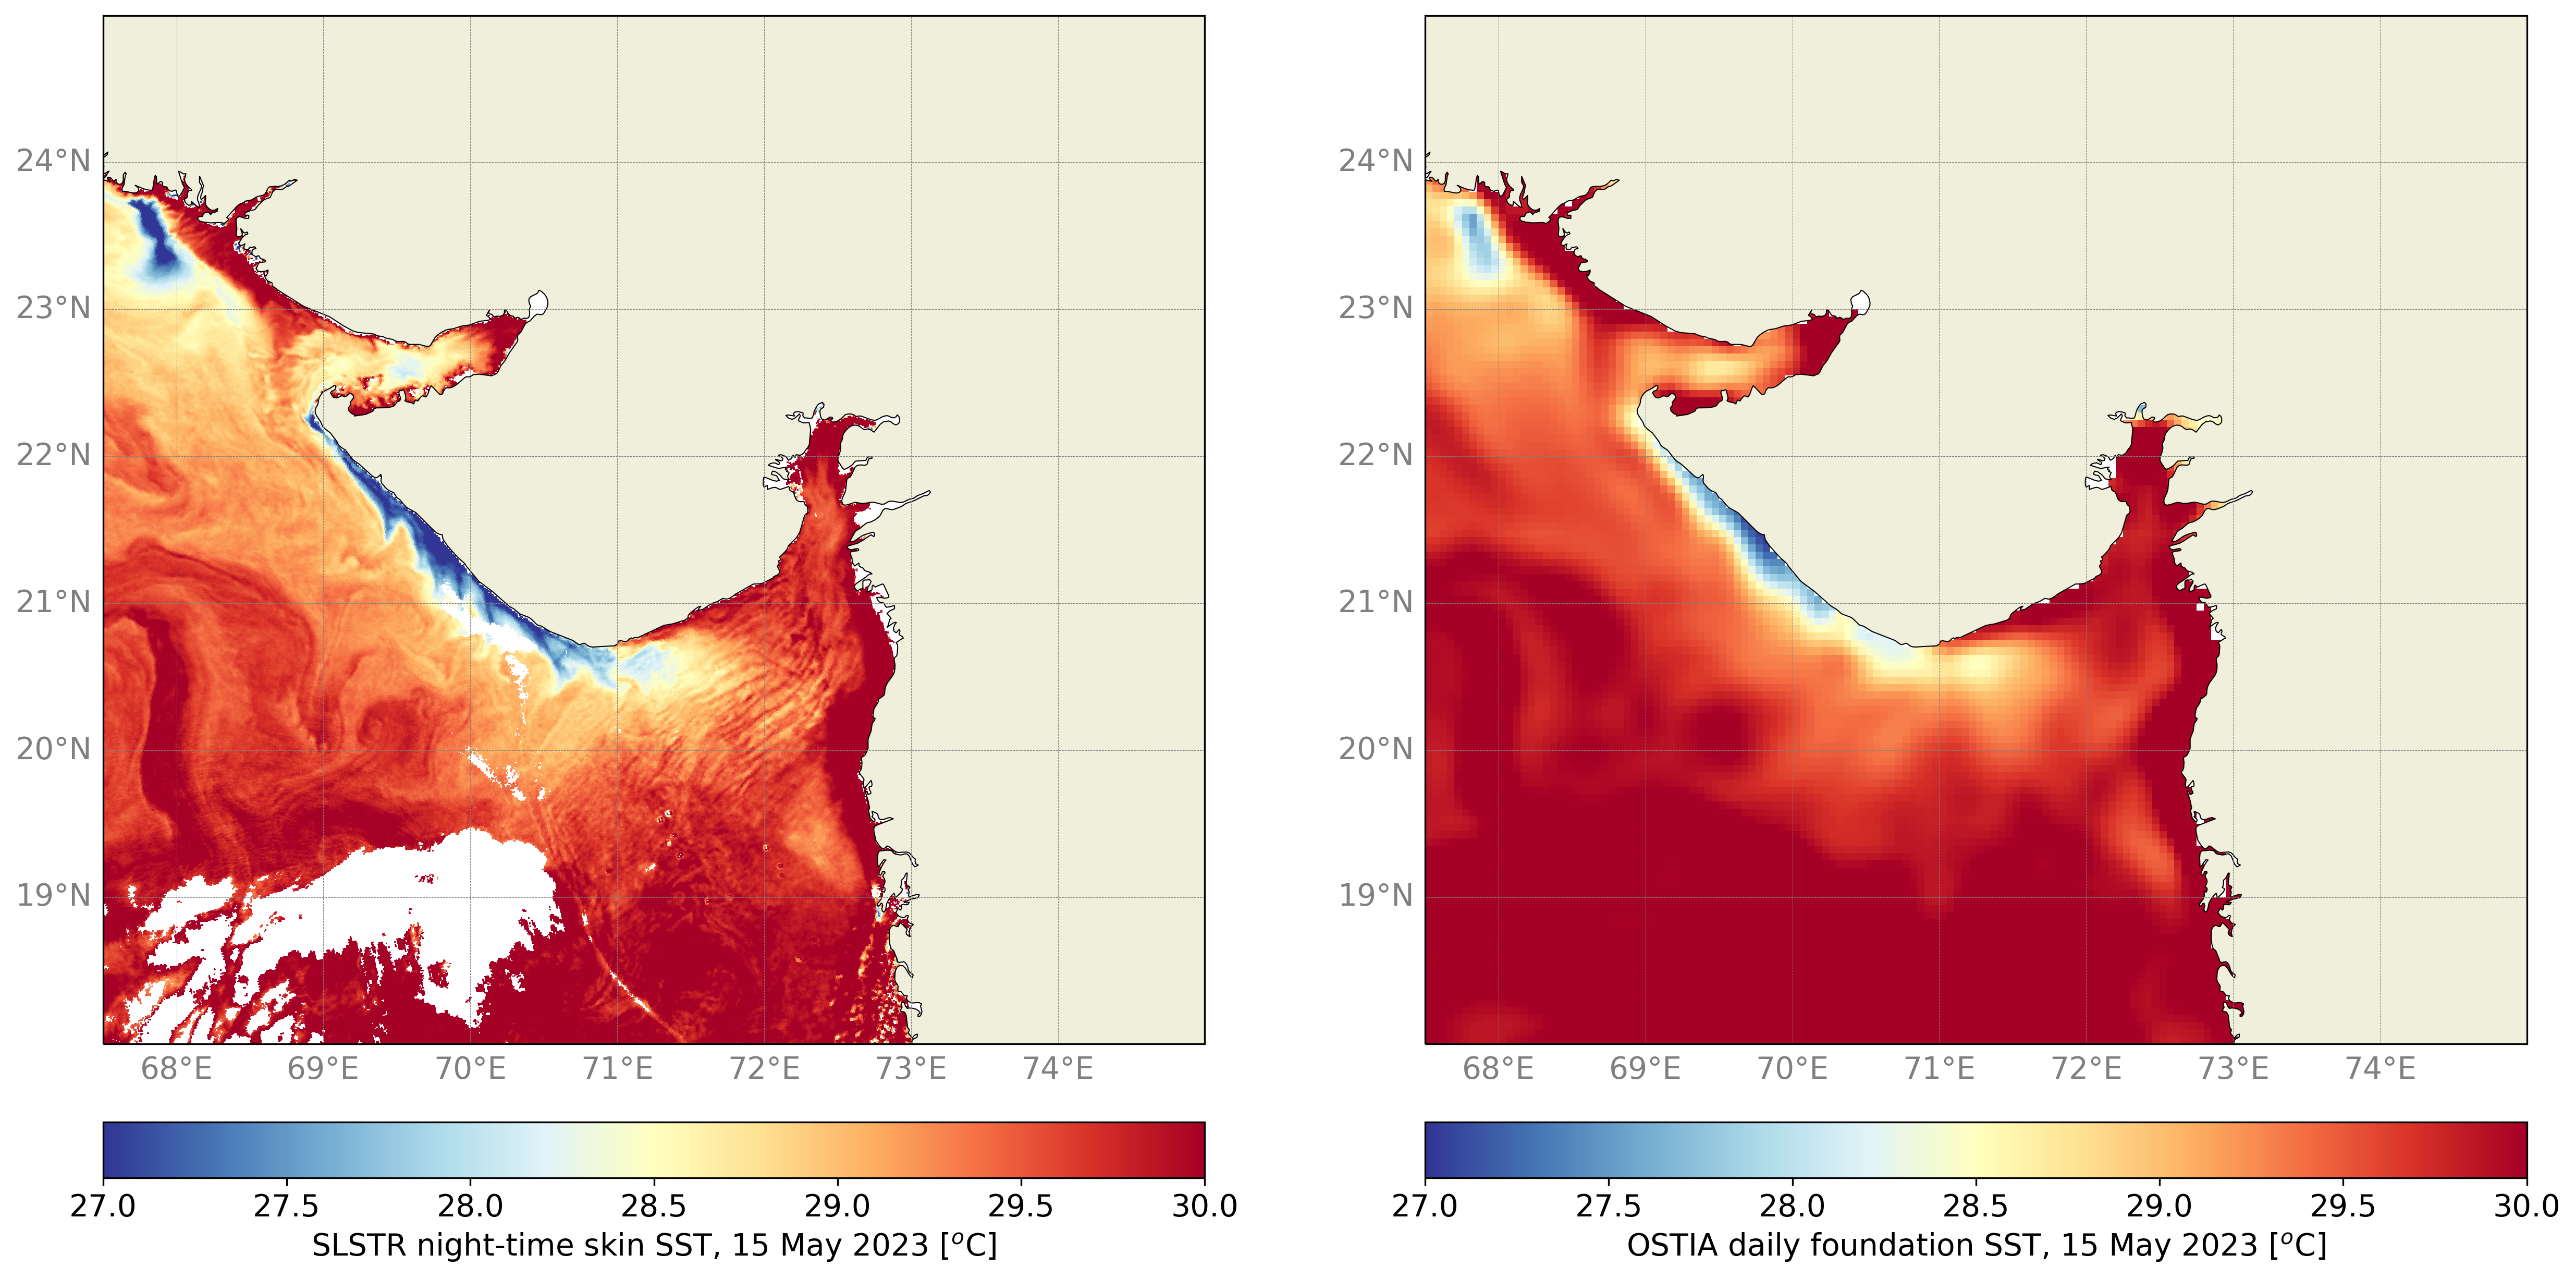

In [26]:
# setup figure
fig = plt.figure(figsize=(20, 10), dpi=300)
plt.rc('font', size=14)

# setup axes
gs = gridspec.GridSpec(3, 2, height_ratios=[20,0.5,1])
gs.update(hspace=0.01)

# setup plot 1: the L2 data
axes_m = plt.subplot(gs[0,0], projection=ccrs.PlateCarree())
axes_m.set_extent(plot_region)
p1 = axes_m.pcolormesh(L2_data["lon"], L2_data["lat"],
                       L2_SST  + k_to_c, cmap=plt.cm.RdYlBu_r,\
                       vmin=27, vmax=30, zorder=-1)
embellish_plot()

# setup: colorbar
axes_c = plt.subplot(gs[2,0])
cbar = plt.colorbar(p1, cax=axes_c, orientation='horizontal')
cbar.ax.tick_params() 
cbar.set_label('SLSTR night-time skin SST, 15 May 2023 [$^{o}$C]')

# setup plot 1: the L4 data
axes_m = plt.subplot(gs[0,1], projection=ccrs.PlateCarree())
axes_m.set_extent(plot_region)
p1 = axes_m.pcolormesh(SST_data["lon"], SST_data["lat"],
                       SST_oper + k_to_c, cmap=plt.cm.RdYlBu_r,\
                       vmin=27, vmax=30, zorder=-1)
embellish_plot()

# setup: colorbar
axes_c = plt.subplot(gs[2,1])
cbar = plt.colorbar(p1, cax=axes_c, orientation='horizontal')
cbar.ax.tick_params() 
cbar.set_label('OSTIA daily foundation SST, 15 May 2023 [$^{o}$C]')

plt.show()

Comparing skin SST and foundation SST is a little dangerous, but we can do it in circumstances where there is no diurnal warming signal (e.g. when our skin temperature is measured at night). It is obvious that the we lose some data from the level-2 product where cloud and other factors conteminate our retrievals. However, it is equally obvious that the increased resolution of the level-2 product (1 km) versus the level-4 product (0.05 degree ~= 5 km) allows us to probe much more of the dynamics. In this case, there is ossible evidence for offshore eddies/meanders, coastal upwelling and possible internal waves.

You should feel to adapt this script for any day you see fit, and it should automatically fetch the corresponding level-4 data, however you will have to manually replace the level-2 product in the "pre_computed" folder for the analagous high resolution SLSTR scene. It is worth noting that I have deliberately chosen a nice clear image - do not be surprised if very few pixels remain in some cases, especially in monsoon season!

<hr>
<a href="https://github.com/wekeo/GHRSST24" target="_blank">View on GitHub</a> | <a href="https://training.eumetsat.int/" target="_blank">EUMETSAT Training</a> | <a href=mailto:ops@eumetsat.int target="_blank">Contact helpdesk for support </a> | <a href=mailto:Copernicus.training@eumetsat.int target="_blank">Contact our training team to collaborate on and reuse this material</a></span></p>